# Machine Learning Case Study

## Read Me

This case consists of a supervised learning example. Your task is to predict the probability of default for the datapoints where the default variable is not set. The answer should contain the resulting predictions in a csv file with two columns, uuid and pd (probability of default==1). Once done expose this model with an API Endpoint on a cloud provider of your choice. Bonus points if youuse AWS. Send us the details on how to query the endpoint, attach code used for modelling, a short (max one page) explanation of your model and how you validated it.

Don’t spend too much time on the prediction results. We evaluate how you structure and reason about the problem rather than the predictive accuracy of your model.

# EDA to answer the task

## Import

In [127]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns



# Preprocessing

from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn import set_config ; set_config(display = 'diagram')
from imblearn.over_sampling import SMOTE


# Model
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

from ml_api.data import storage_upload, get_local_data, drop_features, split_data, get_data_from_gcp



## Load Data

In [90]:
df = pd.read_csv('../raw_data/dataset.csv', sep = ';').set_index('uuid')
df.head()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
uuid,,,,,,,,,,,,,,,,,,,,,
63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,...,1,1,1,1,0,0,0,178839,9.653333,1.0
0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


## Check Duplicates

In [91]:
df.duplicated().sum()

1

In [92]:
df = df.drop_duplicates() 

### Predict data and Train data

The rows with no value in the column default are the one to use for the prediction.
I will create a new dataset called predict_data for those and a train_data dataset for the rows with values (0 or 1) in the default column

In [93]:
predict_data = df[df['default'].isnull() == True]
predict_data = predict_data.drop('default',1)
predict_data.head()

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_74756/3673713014.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  predict_data = predict_data.drop('default',1)


,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
uuid,,,,,,,,,,,,,,,,,,,,,
6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0,0.0,0.0,0.0,0.009135,1.0,1.0,NaN,1.0,1.0,...,1,1,1,1,0,8815,0,27157,19.895556,NaN
f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0.236667,NaN
e9c39869-1bc5-4375-b627-a2df70b445ea,50956,0.0,77.0,0.0,0.000000,1.0,1.0,2.0,3.0,2.0,...,2,1,1,3,0,36163,39846,93760,20.332778,NaN
6beb88a3-9641-4381-beb6-c9a208664dd0,35054,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,...,0,2,2,2,0,62585,0,1790,6.201111,NaN
bb89b735-72fe-42a4-ba06-d63be0f4ca36,0,0.0,0.0,0.0,0.000000,1.0,2.0,NaN,2.0,2.0,...,0,0,0,0,0,14295,0,0,8.451111,NaN


In [94]:
train_data = df[df['default'].isnull() == False]
train_data.head()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
uuid,,,,,,,,,,,,,,,,,,,,,
63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,...,1,1,1,1,0,0,0,178839,9.653333,1.0
0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [95]:
train_data.isnull().sum().sort_values(ascending=False) /len(train_data)

worst_status_active_inv                0.695071
account_worst_status_12_24m            0.667452
account_worst_status_6_12m             0.603634
account_incoming_debt_vs_paid_0_24m    0.593009
account_worst_status_3_6m              0.577238
account_worst_status_0_3m              0.543851
account_status                         0.543851
avg_payment_span_0_3m                  0.493259
avg_payment_span_0_12m                 0.238588
num_active_div_by_paid_inv_0_12m       0.229586
num_arch_written_off_12_24m            0.181206
num_arch_written_off_0_12m             0.181206
account_days_in_rem_12_24m             0.118722
account_days_in_term_12_24m            0.118722
account_days_in_dc_12_24m              0.118722
sum_paid_inv_0_12m                     0.000000
sum_capital_paid_account_12_24m        0.000000
sum_capital_paid_account_0_12m         0.000000
time_hours                             0.000000
status_max_archived_0_24_months        0.000000
status_max_archived_0_12_months        0

## Delete Null Values

First step is to adress null values. In this case I do not hace access to any other input or reason as to why the data is missing
I have two options :
- Discard null values and therefore loose the data
- Imput values to replace the missing ones (using median, mean, mode, ...)

For the sake of this excercice I will discard any column with more than 50% missing data

In [96]:
#funcion to drop columns 
def drop_features(X, feature_list):

    X = X.drop(feature_list,1)
    return X

In [97]:
drop_list = ['account_incoming_debt_vs_paid_0_24m','account_status','account_worst_status_0_3m','account_worst_status_12_24m',\
                 'account_worst_status_3_6m','account_worst_status_6_12m','worst_status_active_inv']
train_data = drop_features(train_data,drop_list)
train_data.head()

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_74756/2952147197.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X.drop(feature_list,1)


,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,...,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
uuid,,,,,,,,,,,,,,,,,,,,,
63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,20,12.692308,8.333333,Dietary supplements,Health & Beauty,...,1,1,1,1,1,0,0,0,178839,9.653333
0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,50,25.833333,25.000000,Books & Magazines,Entertainment,...,1,1,1,2,2,0,0,0,49014,13.181389
d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,22,20.000000,18.000000,Diversified entertainment,Entertainment,...,1,1,1,2,2,0,0,0,124839,11.561944
0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,36,4.687500,4.888889,Diversified entertainment,Entertainment,...,1,1,1,1,1,0,0,0,324676,15.751111
c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,25,13.000000,13.000000,Electronic equipment & Related accessories,Electronics,...,0,0,1,1,1,0,0,0,7100,12.698611


## Check Correlation

<AxesSubplot:>

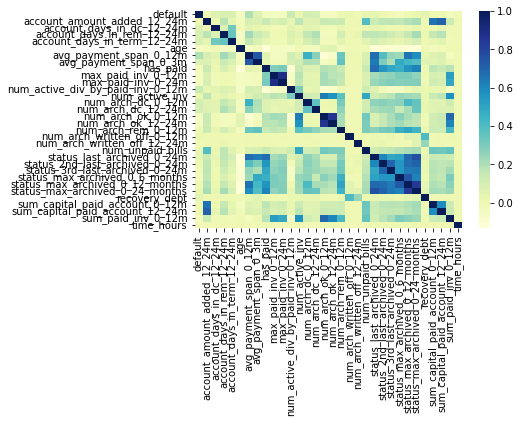

In [98]:
# Heatmap
corr = train_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [99]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(20)

,feature_1,feature_2,correlation
298,max_paid_inv_0_12m,max_paid_inv_0_24m,0.889912
329,max_paid_inv_0_24m,max_paid_inv_0_12m,0.889912
527,num_arch_ok_12_24m,num_arch_ok_0_12m,0.864148
496,num_arch_ok_0_12m,num_arch_ok_12_24m,0.864148
826,status_max_archived_0_12_months,status_max_archived_0_24_months,0.842979
857,status_max_archived_0_24_months,status_max_archived_0_12_months,0.842979
853,status_max_archived_0_24_months,status_last_archived_0_24m,0.765437
698,status_last_archived_0_24m,status_max_archived_0_24_months,0.765437
199,avg_payment_span_0_12m,avg_payment_span_0_3m,0.742573
230,avg_payment_span_0_3m,avg_payment_span_0_12m,0.742573


In [100]:
# dropping highly correlated features
features_drop = ['max_paid_inv_0_24m', 'num_arch_ok_12_24m', 'status_max_archived_0_12_months', 'status_last_archived_0_24m', \
                'avg_payment_span_0_12m', 'status_max_archived_0_12_months','account_amount_added_12_24m',  \
                              'status_max_archived_0_24_months']
train_data = drop_features(train_data,features_drop)

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_74756/2952147197.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X.drop(feature_list,1)


## Train and test sets

In [101]:
# Defining X,y
X = train_data.drop('default', axis = 1)
y = train_data['default']

In [102]:
#Splitting X and y into test and train sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.30)

## Creating Preproc Pipeline

In [103]:
# Using simple imputer to replace the remaining missing values
replace_col = ['avg_payment_span_0_3m','num_active_div_by_paid_inv_0_12m','num_arch_written_off_12_24m', \
                'num_arch_written_off_0_12m','account_days_in_dc_12_24m','account_days_in_rem_12_24m','account_days_in_term_12_24m', \
               'sum_capital_paid_account_12_24m','sum_capital_paid_account_0_12m','recovery_debt']
                                
# Using robust scaler on contiuous values to scale data         
scale_col = ['sum_paid_inv_0_12m', 'time_hours', 'max_paid_inv_0_12m' ]


# Imputing, scaling and Encoding data. Dropping the remaining columns ('merchant_category'  and 'name_in_email')

preproc = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),['merchant_group'] ),
    (OrdinalEncoder(),['has_paid'] ),
    (SimpleImputer(strategy="median"), replace_col),
    (RobustScaler() , scale_col),
    (MinMaxScaler(),  make_column_selector(dtype_include=['int64']) ),
    remainder='drop')




## Modeling

In [104]:
# The Data is unbalanced, I will be using a Synthetic Minority Over-sampling TEchnique - SMOTE technique to balance the data
pipe_lr = make_pipeline (preproc ,SMOTE(), LogisticRegression(max_iter=1000))
pipe_random = make_pipeline (preproc ,SMOTE(), RandomForestClassifier(n_estimators=100))


In [105]:
# cross validating Logistic Regression Model

scores = cross_validate(pipe_lr, X_train, y_train, cv=10) # Cross validate
scores

{'fit_time': array([4.98247194, 1.6102581 , 3.17557001, 3.59884787, 3.5283761 ,
        4.37162995, 3.71774483, 4.23742104, 4.08883905, 2.61271715]),
 'score_time': array([0.02342701, 0.01726508, 0.01802278, 0.01619792, 0.01618695,
        0.01641297, 0.01665497, 0.09164405, 0.02085114, 0.01837993]),
 'test_score': array([0.66836006, 0.66058104, 0.66814862, 0.65989203, 0.66576691,
        0.67148301, 0.66529057, 0.67846936, 0.66719594, 0.67624643])}

In [106]:
# cross validating Random Forest Classifier
cv_results = cross_validate(pipe_random, X_train, y_train, scoring = "r2", cv=10)
cv_results['test_score'].mean()

-0.9725946937319574

In [107]:
pipe_random.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['merchant_group']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['has_paid']),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['avg_payment_span_0_3m',
                                                   'num_active_div_by_paid_inv_0_12m',
                                                   'num_arch_written_off_12_24m',
                                                   'num_arch_writte...
                                                   'sum_capital_paid_account_12_24m',
                                                   'sum_capital_paid_account_0_12m',
                                                   'recovery_debt']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['sum_paid_inv_0_12m',
                                                   'time_hours',
                                                   'max_paid_inv_0_12m']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x127924b50>)])),
                ('smote', SMOTE()),
                ('randomforestclassifier', RandomForestClassifier())])

In [108]:
# Scoring Random Forest Model
pipe_random.score(X_test,y_test)

0.9709554328900085

In [109]:
# Dropping columns on the predict data
predict_data = drop_features(predict_data,drop_list)
predict_data = drop_features(predict_data,features_drop)
predict_data.head()

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_74756/2952147197.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X.drop(feature_list,1)


,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,name_in_email,...,num_arch_written_off_12_24m,num_unpaid_bills,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
uuid,,,,,,,,,,,,,,,,,,,,,
6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0.0,0.0,0.0,20,5.25,Youthful Shoes & Clothing,Clothing & Shoes,True,7225.0,F,...,0.0,1,1,1,1,0,8815,0,27157,19.895556
f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0.0,0.0,0.0,64,NaN,Personal care & Body improvement,Health & Beauty,False,0.0,L1+F,...,NaN,0,0,0,0,0,0,0,0,0.236667
e9c39869-1bc5-4375-b627-a2df70b445ea,0.0,77.0,0.0,28,NaN,Diversified entertainment,Entertainment,True,91980.0,F,...,0.0,0,1,2,1,0,36163,39846,93760,20.332778
6beb88a3-9641-4381-beb6-c9a208664dd0,0.0,0.0,0.0,31,NaN,Concept stores & Miscellaneous,"Leisure, Sport & Hobby",True,1790.0,F+L,...,0.0,0,0,0,2,0,62585,0,1790,6.201111
bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.0,0.0,0.0,30,NaN,Diversified electronics,Electronics,True,0.0,F1+L,...,NaN,0,0,0,0,0,14295,0,0,8.451111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5c03bc63-ea65-4ffd-aa7b-95ea9a46db34,0.0,0.0,0.0,33,NaN,Electronic equipment & Related accessories,Electronics,True,35195.0,F1+L,...,0.0,0,1,1,1,0,0,0,60127,10.765556
f8db22f4-9819-420c-abbc-9ddf1843176e,0.0,0.0,0.0,44,NaN,Body & Hair Care,Health & Beauty,True,4740.0,F1+L,...,0.0,1,1,1,0,0,7948,0,4740,21.708333
b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,0.0,20.0,0.0,24,NaN,Jewelry & Watches,Jewelry & Accessories,True,1200.0,Nick,...,NaN,18,0,0,0,0,17447,19627,3100,2.185278


In [110]:
#predicting default value using the randomForest model
y_pred = pipe_random.predict_proba(pd.DataFrame(predict_data))

In [111]:
pipe_random.predict(pd.DataFrame(predict_data))

array([0., 0., 0., ..., 0., 0., 0.])

In [112]:
len(y_pred[:,0])

10000

In [115]:
# creating a dataFrame with the uuid and the pd
results = pd.concat([pd.Series(predict_data.index), pd.Series(y_pred[:,0], name="pd")], axis=1).set_index('uuid')
results.head()

,pd
uuid,
6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,1.00
f6f6d9f3-ef2b-4329-a388-c6a687f27e70,1.00
e9c39869-1bc5-4375-b627-a2df70b445ea,0.97
6beb88a3-9641-4381-beb6-c9a208664dd0,0.95
bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.98
